In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("/Users/max/MasterThesis/Training/"))

Number of label 1 in the final training set:  5000
Number of label 0 in the final training set (after downsampling):  1000
Number of label 1 in the final test set:  1000
Number of label 0 in the final test set:  1000
Total samples in final training set:  6000
Total samples in final test set:  2000
Number of batches in training set:  94
Number of batches in test set:  32
Images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])


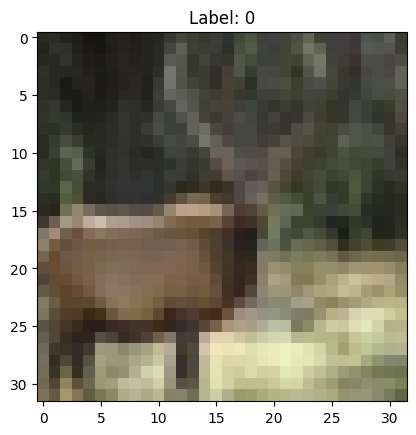

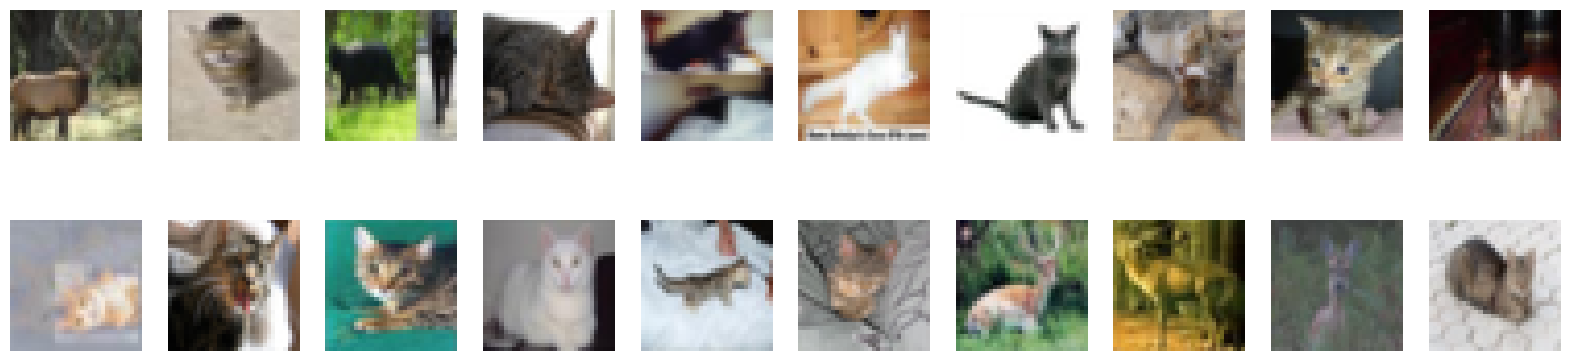

X_train.shape: (6000, 3072)
y_train.shape: (6000,)
X_test.shape: (2000, 3072)
y_test.shape: (2000,)
Resampled dataset shape Counter({np.int64(1): 5000, np.int64(0): 5000})
##############################################
SMOTE done!
X_train.shape: (10000, 3072)
y_train.shape: (10000,)
X_test.shape: (2000, 3072)
y_test.shape: (2000,)


/Users/max/anaconda3/envs/Thesis/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [2]:
from Swim_Maha import SwimMaha
# frac  = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
frac = 0.2
import torch
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
from torchvision import datasets, transforms
import numpy as np

# CIFAR10 数据归一化参数
# 数据预处理
cifar10_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
# 加载 CIFAR10 数据集
full_train_dataset = datasets.CIFAR10(
    root="/Users/max/MasterThesisData/CIFAR10", train=True, transform=cifar10_transforms, download=True)
full_test_dataset = datasets.CIFAR10(
    root="/Users/max/MasterThesisData/CIFAR10", train=False, transform=cifar10_transforms, download=True)

# 筛选训练集中的标签 3 和 4，并映射标签（标签 3 -> 1，标签 4 -> 0）
indices3_train = [i for i in range(len(full_train_dataset)) if full_train_dataset.targets[i] == 3]
indices4_train = [i for i in range(len(full_train_dataset)) if full_train_dataset.targets[i] == 4]

# 筛选测试集中的标签 3 和 4，并映射标签
indices3_test = [i for i in range(len(full_test_dataset)) if full_test_dataset.targets[i] == 3]
indices4_test = [i for i in range(len(full_test_dataset)) if full_test_dataset.targets[i] == 4]

# 训练集：获取标签为 3 的数据（映射为 1）
cifar3_train_data = full_train_dataset.data[indices3_train]  # numpy 数组，形状 (n, 32, 32, 3)
cifar3_train_labels = torch.ones(len(indices3_train), dtype=torch.long)

# 训练集：获取标签为 4 的数据（映射为 0）
cifar4_train_data = full_train_dataset.data[indices4_train]
cifar4_train_labels = torch.zeros(len(indices4_train), dtype=torch.long)

# 测试集：获取标签为 3 的数据（映射为 1）
cifar3_test_data = full_test_dataset.data[indices3_test]
cifar3_test_labels = torch.ones(len(indices3_test), dtype=torch.long)

# 测试集：获取标签为 4 的数据（映射为 0）
cifar4_test_data = full_test_dataset.data[indices4_test]
cifar4_test_labels = torch.zeros(len(indices4_test), dtype=torch.long)

# 控制不平衡比例，比如这里设定为 0.005（即只选取标签 4 数据中的一小部分）
fraction = int(frac * len(cifar3_train_data))
selected_indices_4 = np.random.choice(len(cifar4_train_data), fraction, replace=False)
fraction_cifar4_train_data = cifar4_train_data[selected_indices_4]
fraction_cifar4_train_labels = cifar4_train_labels[selected_indices_4]

# 拼接最终的训练和测试数据集
Final_train_data = np.concatenate([cifar3_train_data, fraction_cifar4_train_data], axis=0)
Final_train_labels = torch.cat([cifar3_train_labels, fraction_cifar4_train_labels], dim=0)

Final_test_data = np.concatenate([cifar3_test_data, cifar4_test_data], axis=0)
Final_test_labels = torch.cat([cifar3_test_labels, cifar4_test_labels], dim=0)

# 将 numpy 数组转换为 tensor，并调整维度为 (N, C, H, W)
Final_train_data = torch.from_numpy(Final_train_data).permute(0, 3, 1, 2).float()
Final_test_data = torch.from_numpy(Final_test_data).permute(0, 3, 1, 2).float()

# 归一化图像数据：先除以 255，再进行标准化
# # 创建 TensorDataset
# Final_train_datasets = TensorDataset(Final_train_data.unsqueeze(3).float() / 255, Final_train_labels)
# Final_test_datasets = TensorDataset(Final_test_data.unsqueeze(3).float() / 255, Final_test_labels)

# 创建 TensorDataset
Final_train_dataset = TensorDataset(Final_train_data.float() / 255, Final_train_labels)
Final_test_dataset = TensorDataset(Final_test_data.float() / 255, Final_test_labels)

# 数据加载器
train_loader = DataLoader(Final_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(Final_test_dataset, batch_size=64, shuffle=False)

# 打印数据信息
print("Number of label 1 in the final training set: ", len(cifar3_train_data))
print("Number of label 0 in the final training set (after downsampling): ", len(fraction_cifar4_train_data))
print("Number of label 1 in the final test set: ", len(cifar3_test_data))
print("Number of label 0 in the final test set: ", len(cifar4_test_data))

print("Total samples in final training set: ", len(Final_train_dataset))
print("Total samples in final test set: ", len(Final_test_dataset))

print("Number of batches in training set: ", len(train_loader))
print("Number of batches in test set: ", len(test_loader))



## 获取一个 batch
images, labels = next(iter(train_loader))

# 打印张量信息
print(f"Images shape: {images.shape}")  # (batch_size, 3, 32, 32)
print(f"Labels shape: {labels.shape}")

# 将第一张图像的维度转换为 (H, W, C) 并显示
img = images[0].permute(1, 2, 0).numpy()  # (32, 32, 3)
plt.imshow(img)  # 对于彩色图像，无需指定 cmap
plt.title(f"Label: {labels[0].item()}")
plt.show()

plt.figure(figsize=(20, 5))
for i, img_tensor in enumerate(images[:20]):
    # 将每张图像转换为 (H, W, C)
    npimg = img_tensor.permute(1, 2, 0).numpy()
    plt.subplot(2, 10, i+1)
    plt.imshow(npimg)  # 彩色图像，不指定 cmap
    plt.axis('off')
plt.show()


X_train = []
y_train = []

for batch in train_loader:
    images, labels = batch  # images: (batch_size, 1, 28, 28), labels: (batch_size,)
    if hasattr(images, 'numpy'): # images is tensor
        images = images.numpy()
    # batch_size = 64
    for img, label in zip(images, labels):
        #print(f"Original shape: {img.shape}")  #  
        flattened_img = img.flatten()           
        #print(f"Flattened shape: {flattened_img.shape}")
        X_train.append(flattened_img) # 
        y_train.append(label)


X_test = [] # features
y_test = [] # labels
for batch in test_loader:
    images, labels = batch  # images: (batch_size, 1,28  ,28 ), labels: (batch_size,)
    if hasattr(images, 'numpy'): # images is tensor
        images = images.numpy()
    # batch_size = 64
    for img, label in zip(images, labels):
        flattened_img = img.flatten()           # flatten the image
        X_test.append(flattened_img)
        y_test.append(label)


X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)
### SMOTE

from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))
print("##############################################")
print("SMOTE done!")
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train_tensor.shape: torch.Size([10000, 3072])
y_train_tensor.shape: torch.Size([10000])
总共恢复的图像数量： 10000


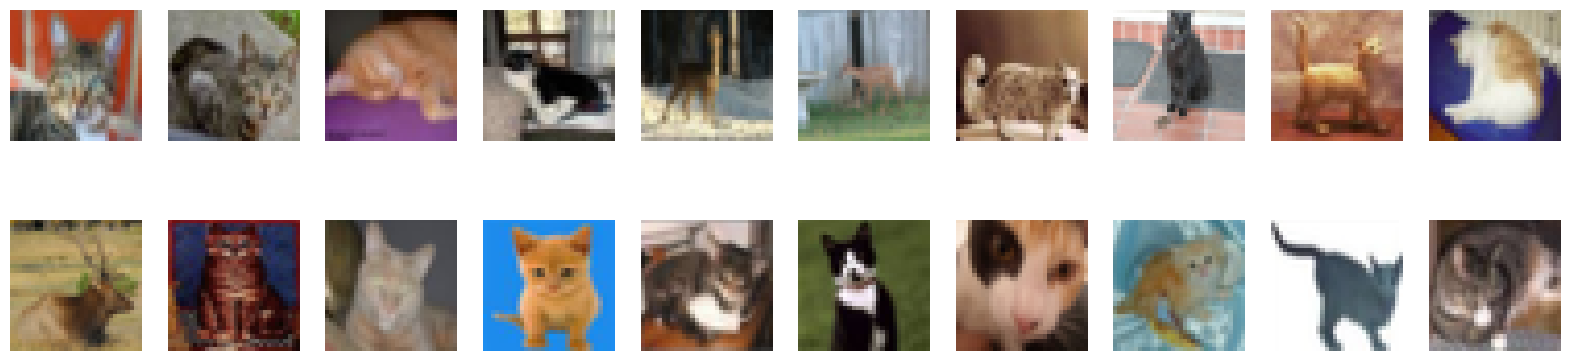

reconstructed_images.shape: torch.Size([10000, 3, 32, 32])
Number of batches in new training set:  157
Images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 假设 X_train 和 y_train 都是 numpy 数组
# 注意：如果你的像素值范围在 0~255，建议在转换为 tensor 时进行归一化
X_train_tensor= torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
print("X_train_tensor.shape:", X_train_tensor.shape)
print("y_train_tensor.shape:", y_train_tensor.shape)

# 假设 X_train_tensor 的形状为 (N, 32*32)，每个样本是一个扁平化的 32x32 图像
reconstructed_images = []  # 用于保存恢复后的图像

for i in range(len(X_train_tensor)):
    flattened_img = X_train_tensor[i]        # 取出第 i 个样本，形状 (32 32,)
    original_img = flattened_img.view(3,32, 32)  # 恢复为 (28, 28) 图像
    reconstructed_images.append(original_img)  # 存入列表

print("总共恢复的图像数量：", len(reconstructed_images))

# 可视化恢复后的图像
plt.figure(figsize=(20, 5))
for i, img in enumerate(reconstructed_images[:20]):
    plt.subplot(2, 10, i+1)
    # 将图像从 (3,32,32) 转换为 (32,32,3) 以供 plt.imshow 显示
    img_np = img.permute(1, 2, 0).numpy()
    plt.imshow(img_np)  # 对于彩色图像，不需要指定 cmap 参数
    plt.axis('off')
plt.show()


# 创建 Dataset
reconstructed_images = torch.stack(reconstructed_images)  # 将列表转换为张量
print("reconstructed_images.shape:", reconstructed_images.shape)  # (N, 32, 32)
final_train_datasets = TensorDataset(reconstructed_images.float(), y_train_tensor)

# 使用新的 Dataset 构建新的 DataLoader
new_train_loader = DataLoader(final_train_datasets, batch_size=64, shuffle=True)
print("Number of batches in new training set: ", len(new_train_loader))

# 获取一个 batch
images, labels = next(iter(new_train_loader))
print(f"Images shape: {images.shape}")  # 形状为 (batch_size, channels, height, width)
print(f"Labels shape: {labels.shape}")  # 形状为 (batch_size,)

In [4]:
from torchinfo import summary
import torch
import torch.nn as nn
from CNN1 import BinaryCNN3
# 将模型转移到GPU中（我们模型运行均在GPU中进行）
model = BinaryCNN3().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
BinaryCNN3                               --
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            147,520
├─Linear: 1-6                            130
Total params: 167,042
Trainable params: 167,042
Non-trainable params: 0

In [5]:
# define the optimizer and loss function
import torch.optim as optimizer
from self_metrics import Binary_got_metrics
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optimizer.Adam(model.parameters(), lr=learning_rate)

# model training
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_accuracy = 0, 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        # Compute prediction error
        prediction = model(images)
        loss = loss_function(prediction, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += (prediction.argmax(1) == labels).type(torch.float).sum().item()

    train_loss /= num_batches
    train_accuracy /= size

    return train_loss, train_accuracy



# model evaluation
def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_accuracy = 0, 0
    # 1(1) is positive, 0(7) is negative
    # TP: 1 classified as 1
    # TN: 0 classified as 0
    # FP: 0 classified as 1
    # FN: 1 classified as 0
    TP, TN, FP, FN = 0, 0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            prediction = model(images)
            test_loss += loss_function(prediction, labels).item()
            test_accuracy += (prediction.argmax(1) == labels).type(torch.float).sum().item()
            TP += ((prediction.argmax(1) == 1) & (labels == 1)).type(torch.float).sum().item()
            TN += ((prediction.argmax(1) == 0) & (labels == 0)).type(torch.float).sum().item()
            FP += ((prediction.argmax(1) == 1) & (labels == 0)).type(torch.float).sum().item()
            FN += ((prediction.argmax(1) == 0) & (labels == 1)).type(torch.float).sum().item()


    test_loss /= num_batches
    test_accuracy /= size
    return test_loss, test_accuracy, TP, TN, FP, FN

# training the model
epochs = 50
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

best_model_TP = 0
best_model_TN = 0
best_model_FP = 0
best_model_FN = 0
best_test_accuracy = 0.0 # for saving the best model
for epoch in range(epochs):
    model.train()
    train_loss, train_accuracy = train(new_train_loader, model, loss_function, optimizer)
    model.eval()
    test_loss, test_accuracy,TP, TN, FP, FN  = test(test_loader, model, loss_function)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}") 

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_model_TP = TP
        best_model_TN = TN
        best_model_FP = FP
        best_model_FN = FN
        save_path = f"BinaryCIFAR1034_{fraction}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"==> New best model saved at epoch {epoch+1} with Test Accuracy: {test_accuracy:.4f}")
        #print(f"==> TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
        Accuracy, misclassification_rate, Sensitivity, Specificity, Precision, Negative_Predictive_Value, Gmean, Fmean, DPower, F2measure, InvF_05, AGFmeasure, Balanced_Accuracy, MCCmeasure, Kappa, Youden_Index, LR_pos, LR_neg = Binary_got_metrics(best_model_TP, best_model_FP, best_model_FN, best_model_TN)
        import json

        # 构造一个包含所有指标数据的字典
        metrics_dict = {
            "Number of label 3 in the final training set": len(cifar3_train_data),
            "Number of label 4 in the final training set (after downsampling)": len(fraction_cifar4_train_data),
            "Number of label 3 in the final test set": len(cifar3_test_data),
            "Number of label 4 in the final test set": len(cifar4_test_data),
            "Total samples in final training set": len(Final_train_dataset),
            "Total samples in final test set": len(Final_test_dataset),
            "Number of batches in training set": len(train_loader),
            "Number of batches in test set": len(test_loader),
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "TN": TN,
            "Accuracy": round(Accuracy, 4),
            "Misclassification rate": round(misclassification_rate, 4),
            "Sensitivity (Recall)": round(Sensitivity, 4),
            "Specificity": round(Specificity, 4),
            "Precision": round(Precision, 4),
            "Negative Predictive Value": round(Negative_Predictive_Value, 4),
            "G-mean": round(Gmean, 4),
            "F-measure": round(Fmean, 4),
            "Discriminant Power (DP)": round(DPower, 4),
            "F2-measure": round(F2measure, 4),
            "InvF0.5-measure": round(InvF_05, 4),
            "AGF": round(AGFmeasure, 4),
            "Balanced Accuracy": round(Balanced_Accuracy, 4),
            "Matthew's Correlation Coefficient (MCC)": round(MCCmeasure, 4),
            "Cohen's Kappa": round(Kappa, 4),
            "Youden's Index": round(Youden_Index, 4),
            "Positive Likelihood Ratio (LR+)": round(LR_pos, 4),
            "Negative Likelihood Ratio (LR-)": round(LR_neg, 4)
        }

        # 指定 JSON 文件保存路径
        metrics_results_path = f"SMOTE_CNNBinaryCIFAR1034_{fraction}_metrics_results.json"

        # 将字典保存为 JSON 文件
        with open(metrics_results_path, "w") as f:
            json.dump(metrics_dict, f, indent=4)

Epoch: 1/50, Train Loss: 0.4917, Train Accuracy: 0.7456, Test Loss: 0.5604, Test Accuracy: 0.7450
==> New best model saved at epoch 1 with Test Accuracy: 0.7450
TP: 811.0
FP: 321.0
FN: 189.0
TN: 679.0
Accuracy: 0.7450
Misclassification rate: 0.2550
Sensitivity (Recall): 0.8110
Specificity: 0.6790
Precision: 0.7164
Negative Predictive Value: 0.7823
G-mean: 0.7421
F-measure: 0.7608
Discriminant Power: 1.2161
F2-measure: 0.7335
InvF0.5-measure: 0.7901
AGF: 0.7613
Balanced Accuracy: 0.7450
Matthew's Correlation Coefficient: 0.4943
Cohen's Kappa: 0.4900
Youden's Index: 0.4900
Positive Likelihood Ratio: 2.5265
Negative Likelihood Ratio: 0.2784
Epoch: 2/50, Train Loss: 0.3454, Train Accuracy: 0.8538, Test Loss: 0.5278, Test Accuracy: 0.7630
==> New best model saved at epoch 2 with Test Accuracy: 0.7630
TP: 825.0
FP: 299.0
FN: 175.0
TN: 701.0
Accuracy: 0.7630
Misclassification rate: 0.2370
Sensitivity (Recall): 0.8250
Specificity: 0.7010
Precision: 0.7340
Negative Predictive Value: 0.8002
G-me